In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy.stats import gamma
import functools
import matplotlib.animation as animation
import itertools


In [2]:
import warnings # Supress warnings
warnings.filterwarnings('ignore')

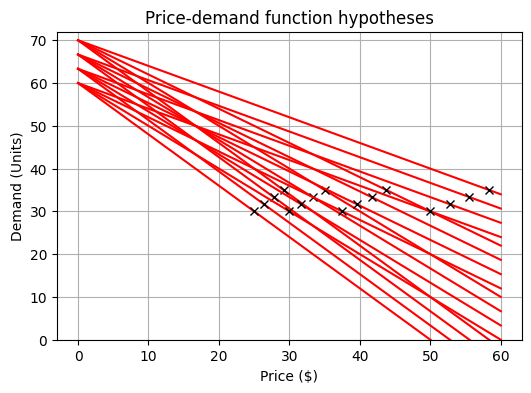

In [3]:
# Generate a set of hypothesis. We use linear demand functions
# for the sake of illustration, although it is reasonable choice for production as well

def linear(a, b, x):        #This function defines a linear demand function with two coefficients, a and b, and an input variable x.
    return b + a*x          # line equation

# A linear demand function is generated for every pair of coefficients in vectors a_vec and b_vec
def demand_hypotheses(a_vec, b_vec):
    for a, b in itertools.product(a_vec, b_vec):
        yield {
            'd': functools.partial(linear, a, b),   # price-demand function
            'p_opt': -b/(2*a)                       # corresponding optimal price
        }
#Each dictionary contains the demand function ('d') and the corresponding optimal price ('p_opt') calculated using the quadratic formula -b/(2*a).

#These variables define the range of a values to consider when generating demand hypotheses.
start = -1.2
end = -0.6

# A list of demand function hypotheses and corresponding optimal prices
h_vec = list(demand_hypotheses(np.linspace(start, end, 4), np.linspace(60, 70, 4)))

prices = np.linspace(0, 60, 100)
fig = plt.figure(figsize=(6, 4))
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.ylim(0, 72)
plt.title('Price-demand function hypotheses')
plt.grid(True)
for d in h_vec:
    plt.plot(prices, list(map(d['d'], prices)), 'r-')
    plt.plot([d['p_opt']], d['d'](d['p_opt']), 'kx', linewidth=0.2)
plt.show()

Each red curve represents a different demand function hypothesis based on combinations of 'a' and 'b'. The black "x" markers indicate the optimal prices corresponding to each demand curve.

The coefficient 'a' represents the price sensitivity or elasticity of demand. It measures how the quantity demanded changes in response to a change in price. A higher absolute value of a indicates a more elastic demand, meaning that consumers are more responsive to price changes. Conversely, a lower absolute value of a indicates a less elastic demand, indicating that consumers are less responsive to price changes.

The coefficient 'b' represents the intercept of the demand curve, which is the quantity demanded when the price is zero. It can also be thought of as the maximum quantity that consumers are willing to buy at a price of zero. It reflects the level of demand regardless of price.

By varying the values of a and b, we can model different demand scenarios. For example:

If a is large (negative), it indicates that demand is very price-sensitive, and small price changes result in significant quantity changes.
If b is large, it indicates a high baseline demand even at higher prices.

The plot visualizes how different combinations of a and b affect the shape of the demand curve and the location of the optimal price. This can be useful for analyzing how changes in demand parameters impact pricing decisions and quantity demanded.

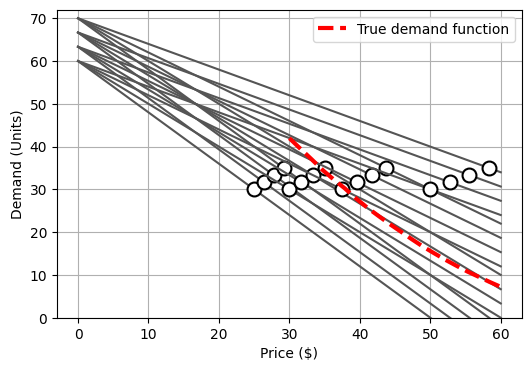

In [4]:
# Define and visualize emperical demand curve

#This function simulates actual demand based on a given price. It uses a gamma distribution to model the demand.
#The parameters avg_demand, theta, and k are calculated based on the price, and a random sample from the gamma distribution is returned as the demand.
def sample_actual_demand(price):
    avg_demand = 65 + (-0.8) * price
    theta = 0.1/4
    k = avg_demand / theta
    return np.random.gamma(k*theta, k*theta**2, 1)[0]

#This function calculates the empirical mean by repeatedly sampling from a given sampler function n times and averaging the results.
def emperical_mean(sampler, n):
    mean = 0
    for i in range(1, n):
        mean = mean + sampler()
    return mean/n

#This function calculates the empirical demand curve.
#It iterates over different prices, calculates the empirical mean demand for each price,
#and returns a numpy array containing the price and corresponding demand values.
def emperical_demand_curve(min_price, max_price, n):
    prices = np.linspace(min_price, max_price, n)
    sampling = 5000
    demands = map(lambda p: emperical_mean(functools.partial(sample_actual_demand, p), sampling), prices)
    return np.dstack((prices, list(demands)))[0]

#It calculates the empirical demand curve using the emperical_demand_curve function for a specified price range (from 30 to 60) and number of points (20).
curve = np.transpose(emperical_demand_curve(30, 60, 20))

fig = plt.figure(figsize=(6, 4))
for i, d in enumerate(h_vec):
    plt.plot(prices, list(map(d['d'], prices)), '-', color='#555555');
    plt.plot([d['p_opt']], d['d'](d['p_opt']), 'ko', markeredgewidth=1.5, markerfacecolor='w', markersize=10)

plt.plot(curve[0], curve[1], 'r--', linewidth=3.0, label='True demand function')
plt.xlabel('Price ($)')
plt.ylabel('Demand (Units)')
plt.ylim(0, 72)
plt.grid(True)
plt.legend()
#plt.savefig('hypoteses.pdf')

plt.show()


The graphical output of the code is a plot that visualizes multiple demand hypotheses (gray lines with black markers) and compares them to a "true" demand function (red dashed line). Each gray line represents a different demand scenario based on the coefficients a and b, while the red dashed line represents the empirical demand curve based on the sample_actual_demand function. The black circle markers indicate the optimal price for each demand hypothesis.

This plot helps in visualizing how different demand hypotheses compare to the empirical demand curve and provides insights into the impact of different demand scenarios on pricing decisions.

In [5]:

def logx(x, n):
    for i in range(0, n):
        x = math.log(x) if x>0 else 0
    return x

def rounds(m, T, scale):
    mask = []
    for i in range(1, m):
        mask.extend( np.full(scale * math.ceil(logx(T, m - i)), i-1) )
    return np.append(mask, np.full(T - len(mask), m-1))

T = 24 + 1  # time step is one hour, 10 days total
m = 4       # not more than 4 price updates

tau = 0
d = h_vec[0]['d']
p = h_vec[0]['p_opt']

t_mask = rounds(m, T, 2)                      # generate the price change schedule in advance

history = []
for t in range(0, T-1):                       # simulation loop
    realized_d = sample_actual_demand(p)

    history.append([p, realized_d, d, p])

    if( t_mask[t] != t_mask[t + 1] ):         # it's time to re-optimize the price
        interval_demands = np.array(history)[tau : t + 1, 1]
        interval_avg_demand = np.mean(interval_demands)

        min_error = float("inf")
        for i, h in enumerate(h_vec):                      # look for a hypothesis that explains
            error = abs(interval_avg_demand - h['d'](p))   # the observed data with a minimal error
            if(error < min_error):
                min_error = error
                h_opt = h

        p = h_opt['p_opt']                    # optimal price for the next price period
        d = h_opt['d']
        tau = t+1

history = np.array(history)

This code simulates a pricing optimization process over a 10-day period, with up to four possible price updates. It maintains a history of price and demand data over time, updating prices when necessary to optimize demand. The optimization is based on various demand function hypotheses stored in h_vec. The code calculates realized demand, averages demand within price intervals, and selects the hypothesis that best explains the data. The result is a history of price and demand data captured during the simulation.

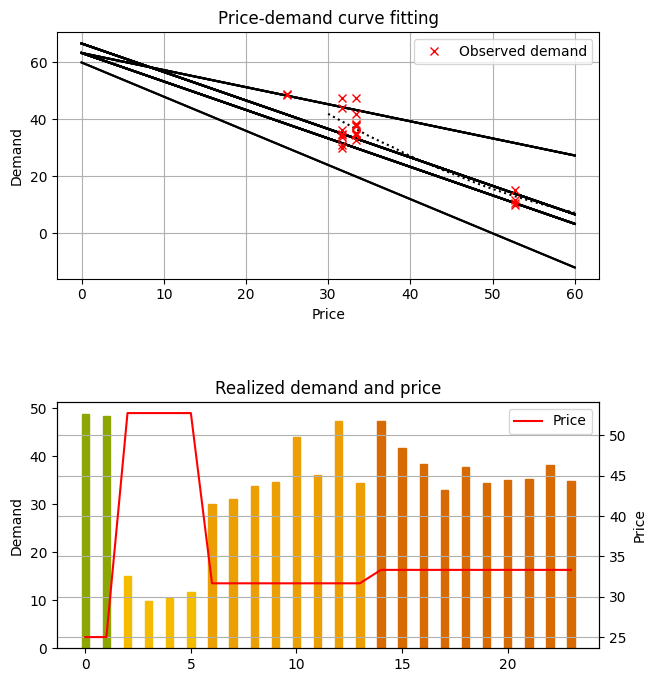

In [6]:
colors = ['#8EA604', '#F5BB00', '#EC9F05', '#D76A03']

def visualize_snapshot(t):
    fig.clear()

    plt.subplot(2, 1, 1)
    plt.xlabel('Price')
    plt.ylabel('Demand')
    plt.title('Price-demand curve fitting')
    plt.plot(curve[0], curve[1], 'k:')
    plt.grid(True)
    for i in range(0, t):
        plt.plot(prices, list(map(history[i, 2], prices)), 'k-')
    plt.plot(history[0:t+1, 0], history[0:t+1, 1], 'rx', label='Observed demand')
    plt.legend()

    ax1 = plt.subplot(2, 1, 2)
    ax1.set_ylabel('Demand')
    bars = ax1.bar(range(0, T-1), np.pad(history[0:t+1, 1], (0, T-2-t), 'constant'), 0.35, label='Demand')
    for i in range(0, t+1):
        bars[i].set_color(colors[t_mask[i]])

    ax2 = ax1.twinx()
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Price')
    ax2.set_title('Realized demand and price')
    ax2.plot(range(0, t+1), history[0:t+1,0], 'r-', label='Price')
    ax2.grid(True)
    ax2.legend()

    plt.savefig('simulation-4.pdf')

fig = plt.figure(figsize=(7, 8))
plt.subplots_adjust(hspace=0.5)
visualize_snapshot(23)               # visualize the state in the end of the simulation
plt.show()

This visualization provides insights into how prices and demand evolve over time in the simulation, allowing for the examination of the pricing strategy's effectiveness.

The first subplot shows the price-demand curve fitting, including the "true" demand curve (black dashed line) and observed demand points (red "x" markers).

The second subplot displays demand as bars and price as a line, both overlaid on the same axes. The color of each bar corresponds to the price change schedule, and the price is shown as a red line.



In [7]:
!pip install pillow

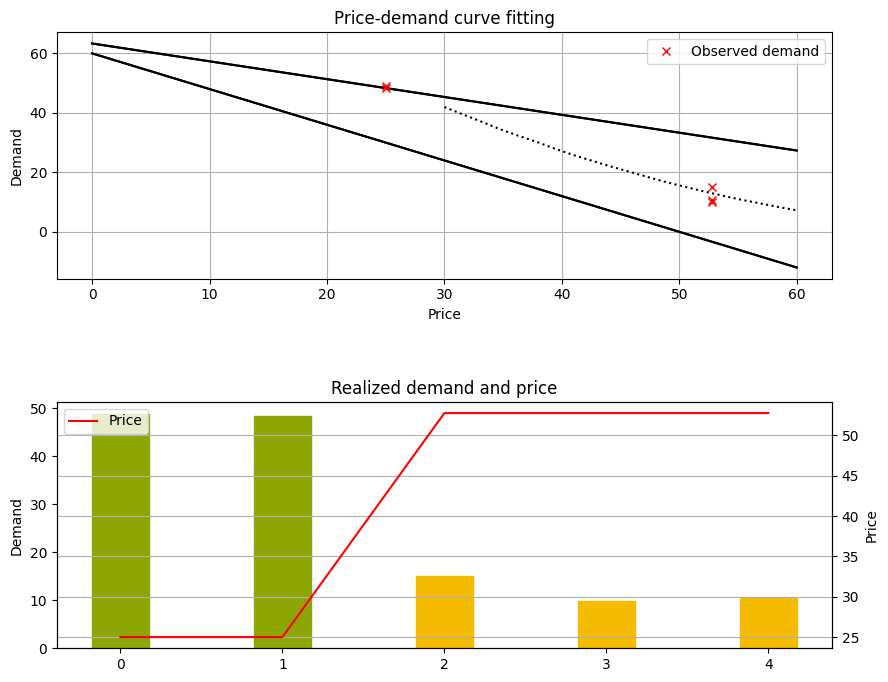

In [11]:
# Render and save the animation of the simulation process
t = 0
def animate(f):
    global t
    visualize_snapshot(t)
    t = t + 1

Writer = animation.writers['pillow']
writer = Writer(fps = 10, bitrate = 2800)

fig = plt.figure(figsize=(10, 8))
plt.subplots_adjust(hspace=0.5)
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = T-2, repeat=True)

ani.save('price_optimization_test_run.gif', writer='imagemagick', fps = 10, dpi = 90)

plt.show()

these graphs provide a visual representation of the simulation's dynamics, showing how prices and demand fluctuate over time. They allow us to analyze how the pricing strategy impacts demand and how observed demand deviates from the theoretical or "true" demand curve.